# Movie Review Text Classifier

Ian Kollipara

CS 392 Seminar in Data Science

2022.04.04


In [15]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import nltk
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("omw-1.4")
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from wordcloud import WordCloud

from sklearn.experimental import enable_halving_search_cv
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, train_test_split, cross_val_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ikollipara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ikollipara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ikollipara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("movie.csv")
print(df.shape)
df.head(5)

(40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Data Exploration
The following dataset is a collection of movie reviews, with a label indicating whether the review is positive or negative. This is denoted with the `label` column, where 1 is Positive and 0 is negative.

A helpful column in visualizing this data is the length of the reivews, which we can add here.

In [3]:
df["length"] = df["text"].map(lambda text: len(text))
df.head(5)

,text,label,length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983


Following this, we can view the distribution of Negative vs. Positive Reviews.

,text,length
label,,
0,20019,20019
1,19981,19981


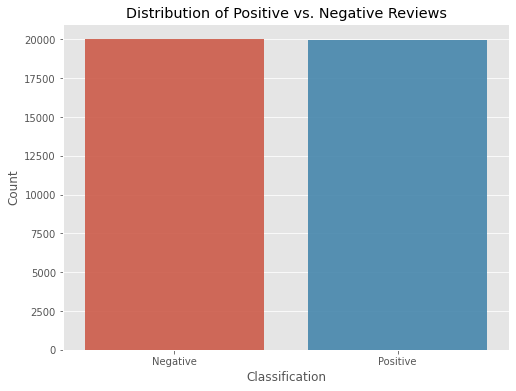

In [5]:
values = df["label"].value_counts().values
plt.figure(figsize=(8, 6))
sns.barplot(x=["Negative", "Positive"], y=values, alpha=0.9)

plt.title("Distribution of Positive vs. Negative Reviews")
plt.ylabel("Count")
plt.xlabel("Classification")
df.groupby("label").count()

From here we can see a nearly even distribution, which is ideal for the data, as we have a lot for both. Given this, we can next look at the average length of a review for each classification to see if there's any noticable behavior.

In [6]:
df.groupby("label")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,20019.0,1292.536990,942.220087,32.0,705.0,973.0,1571.0,8969.0
1,19981.0,1328.083279,1032.236721,65.0,690.0,972.0,1621.0,13704.0


As shown here, the $\mu \approx 1293$ and $\sigma \approx 1000$. Given this, we can create a threshold of $t = 2300$. 

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

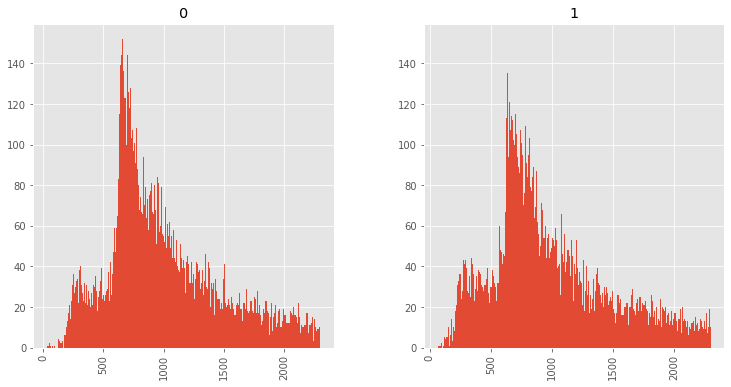

In [8]:
t = 2300
df[df["length"] < t].hist("length", by="label", bins=500, figsize=(12, 6))

This shows that a majority of the reviews lie within the range of $500 \rightarrow 1250$. 

The next major observation is that of long reviews, that is reviews that are above $t$. In these reviews, a noticable pattern emerges.

,text,length
label,,
0,2398,2398
1,2739,2739


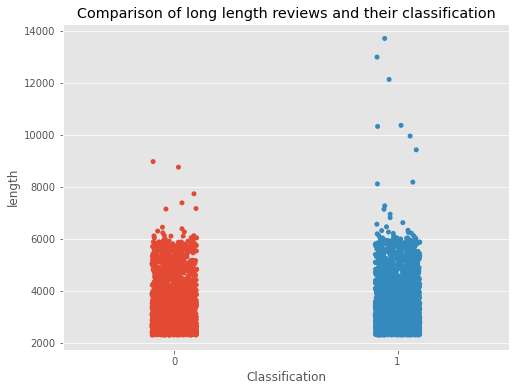

In [10]:
plt.figure(figsize=(8, 6))
sns.stripplot(y="length", x="label", data=df[df["length"] > t])
plt.title("Comparison of long length reviews and their classification")
plt.xlabel("Classification")
df[df["length"] > t].groupby("label").count()

There appears to be a correlation between long reviews and positive classification. This is evident when the pearson correlation coeffienct is calculated.

In [12]:
df[df["length"] > t].corr()

,label,length
label,1.000000,0.044712
length,0.044712,1.000000


Beyond this, there isn't much to note about the data yet. More visualization happens after some parts of feature extraction.

## Feature Extraction
### Lemmatization/Stemming
The process of lemmatization/stemming involves breaking a word down to its root - or rather stem - so that the feature count might be a lot smaller. In general the feature count for NLP easily balloons, so measures like Lemmatization/Stemming help alievate the issue.

In my case, I chose to use [Princeton's WordNet](https://wordnet.princeton.edu/). Wordnet is a lemmatizer, meaning the part of speech matters when stemming a word. Given this, I also tested with a regular stemmer in which I chose the [Lancaster Algorithm](https://www.nltk.org/api/nltk.stem.lancaster.html), based on the paper *Another Stemmer* by Chris D. Paice.

Both of these are readily available in NLTK.

In [13]:
X = df['text']
y = df['label']

#### Wordnet

In [25]:
%%time

lemmatizer = WordNetLemmatizer()

def lemmatize(text: str) -> str:
    lemmatized_review = (lemmatizer.lemmatize(w.lower()) for w in nltk.wordpunct_tokenize(text))
    return " ".join(lemmatized_review)

X_lemmatized = X.map(lambda text: lemmatize(text))

CPU times: user 1min 7s, sys: 99 ms, total: 1min 7s
Wall time: 1min 8s


#### Lancaster

In [26]:
%%time

stemmer = LancasterStemmer()

def stem(text: str) -> str:
    stemmed_review = (stemmer.stem(w.lower()) for w in nltk.wordpunct_tokenize(text))
    return " ".join(stemmed_review)

X_stemmed = X.map(lambda text: stem(text))

CPU times: user 2min 56s, sys: 144 ms, total: 2min 56s
Wall time: 2min 58s


Following this, we can now move to stop word removal.

### Stop Word Removal
The reason stemming/lemmatizing comes before Stop Word Removal is due to the fact the stop words must be lemmatized/stemmed as well. These words are then removed from the reviews, so as to limit our features.

The definition of a stop word is subjective, as its simply a word that hold no meaning in relation to the classification. As such I have built a stop word collection of [Google's stop words](https://www.ranks.nl/stopwords) and a collection used prior for [movie review classification](https://github.com/rashmishrm/Movie-Reviews-Classification/blob/master/stop-words.txt).

These will be done with both Wordnet and Lancaster.

#### Wordnet

In [27]:
%%time

with open("stop-words.txt") as f:
    stop_words_lemmatized = [lemmatizer.lemmatize(w.strip("\n")) for w in f]

def filter_by_stop_words(text: str) -> str:
    review = []
    for word in nltk.wordpunct_tokenize(text):
        if word not in stop_words_lemmatized:
            review.append(word)
    return " ".join(review)
        
X_lemmatized = X_lemmatized.map(lambda text: filter_by_stop_words(text))

CPU times: user 43.8 s, sys: 41.6 ms, total: 43.8 s
Wall time: 44 s


#### Lancaster

In [28]:
%%time

with open("stop-words.txt") as f:
    stop_words_stemmed = [stemmer.stem(w.strip("\n")) for w in f]
    
def filter_by_stop_words(text: str) -> str:
    review = []
    for word in nltk.wordpunct_tokenize(text):
        if word not in stop_words_stemmed:
            review.append(word)
    return " ".join(review)

X_stemmed = X_stemmed.map(lambda text: filter_by_stop_words(text))

CPU times: user 43.1 s, sys: 9.13 ms, total: 43.1 s
Wall time: 43.3 s


With the stop words removed, the last step is vectorization. However, before we vectorize there are some visualizations we can do. 

One is simply comparing the stemmed/lemmatized version to the original version. The other is word clouds. Both are used.

### Visualizations
#### Comparing Random Reviews

In [29]:
print("Original:")
print(df["text"][171])
print()
print("Lemmatization:")
print(X_lemmatized[171])
print()
print("Stemmed:")
print(X_stemmed[171])

Original:
I have to say although this movie was formulaic throughout with a plot stolen from films like Friday the 13th/I Know What You Did Last Summer, this movie wasn't that bad. In fact it wasn't as bad as most of the Horror films Hollywood has released recently. The killings although at times a little too imaginative were in most instances just that, original. The cast was mediocre which is to be expected from low-budget features but much better than what that much bigger studio Artisan/Lions Gate has been offering. My only real complaint that wasn't due to the film's budget, which must have been small, was the contrived "twist" ending. I'm sorry but this is what put this film in the bad category for me. The ending was just stupid and tacked on. Before that I was a little bored, but actually enjoying it. 4/10

Lemmatization:
say although movie formulaic throughout plot stolen film like friday 13th / know last summer , movie ' bad . fact ' bad horror film hollywood released recently

#### WordClouds
##### Lemmatized

(-0.5, 2999.5, 1999.5, -0.5)

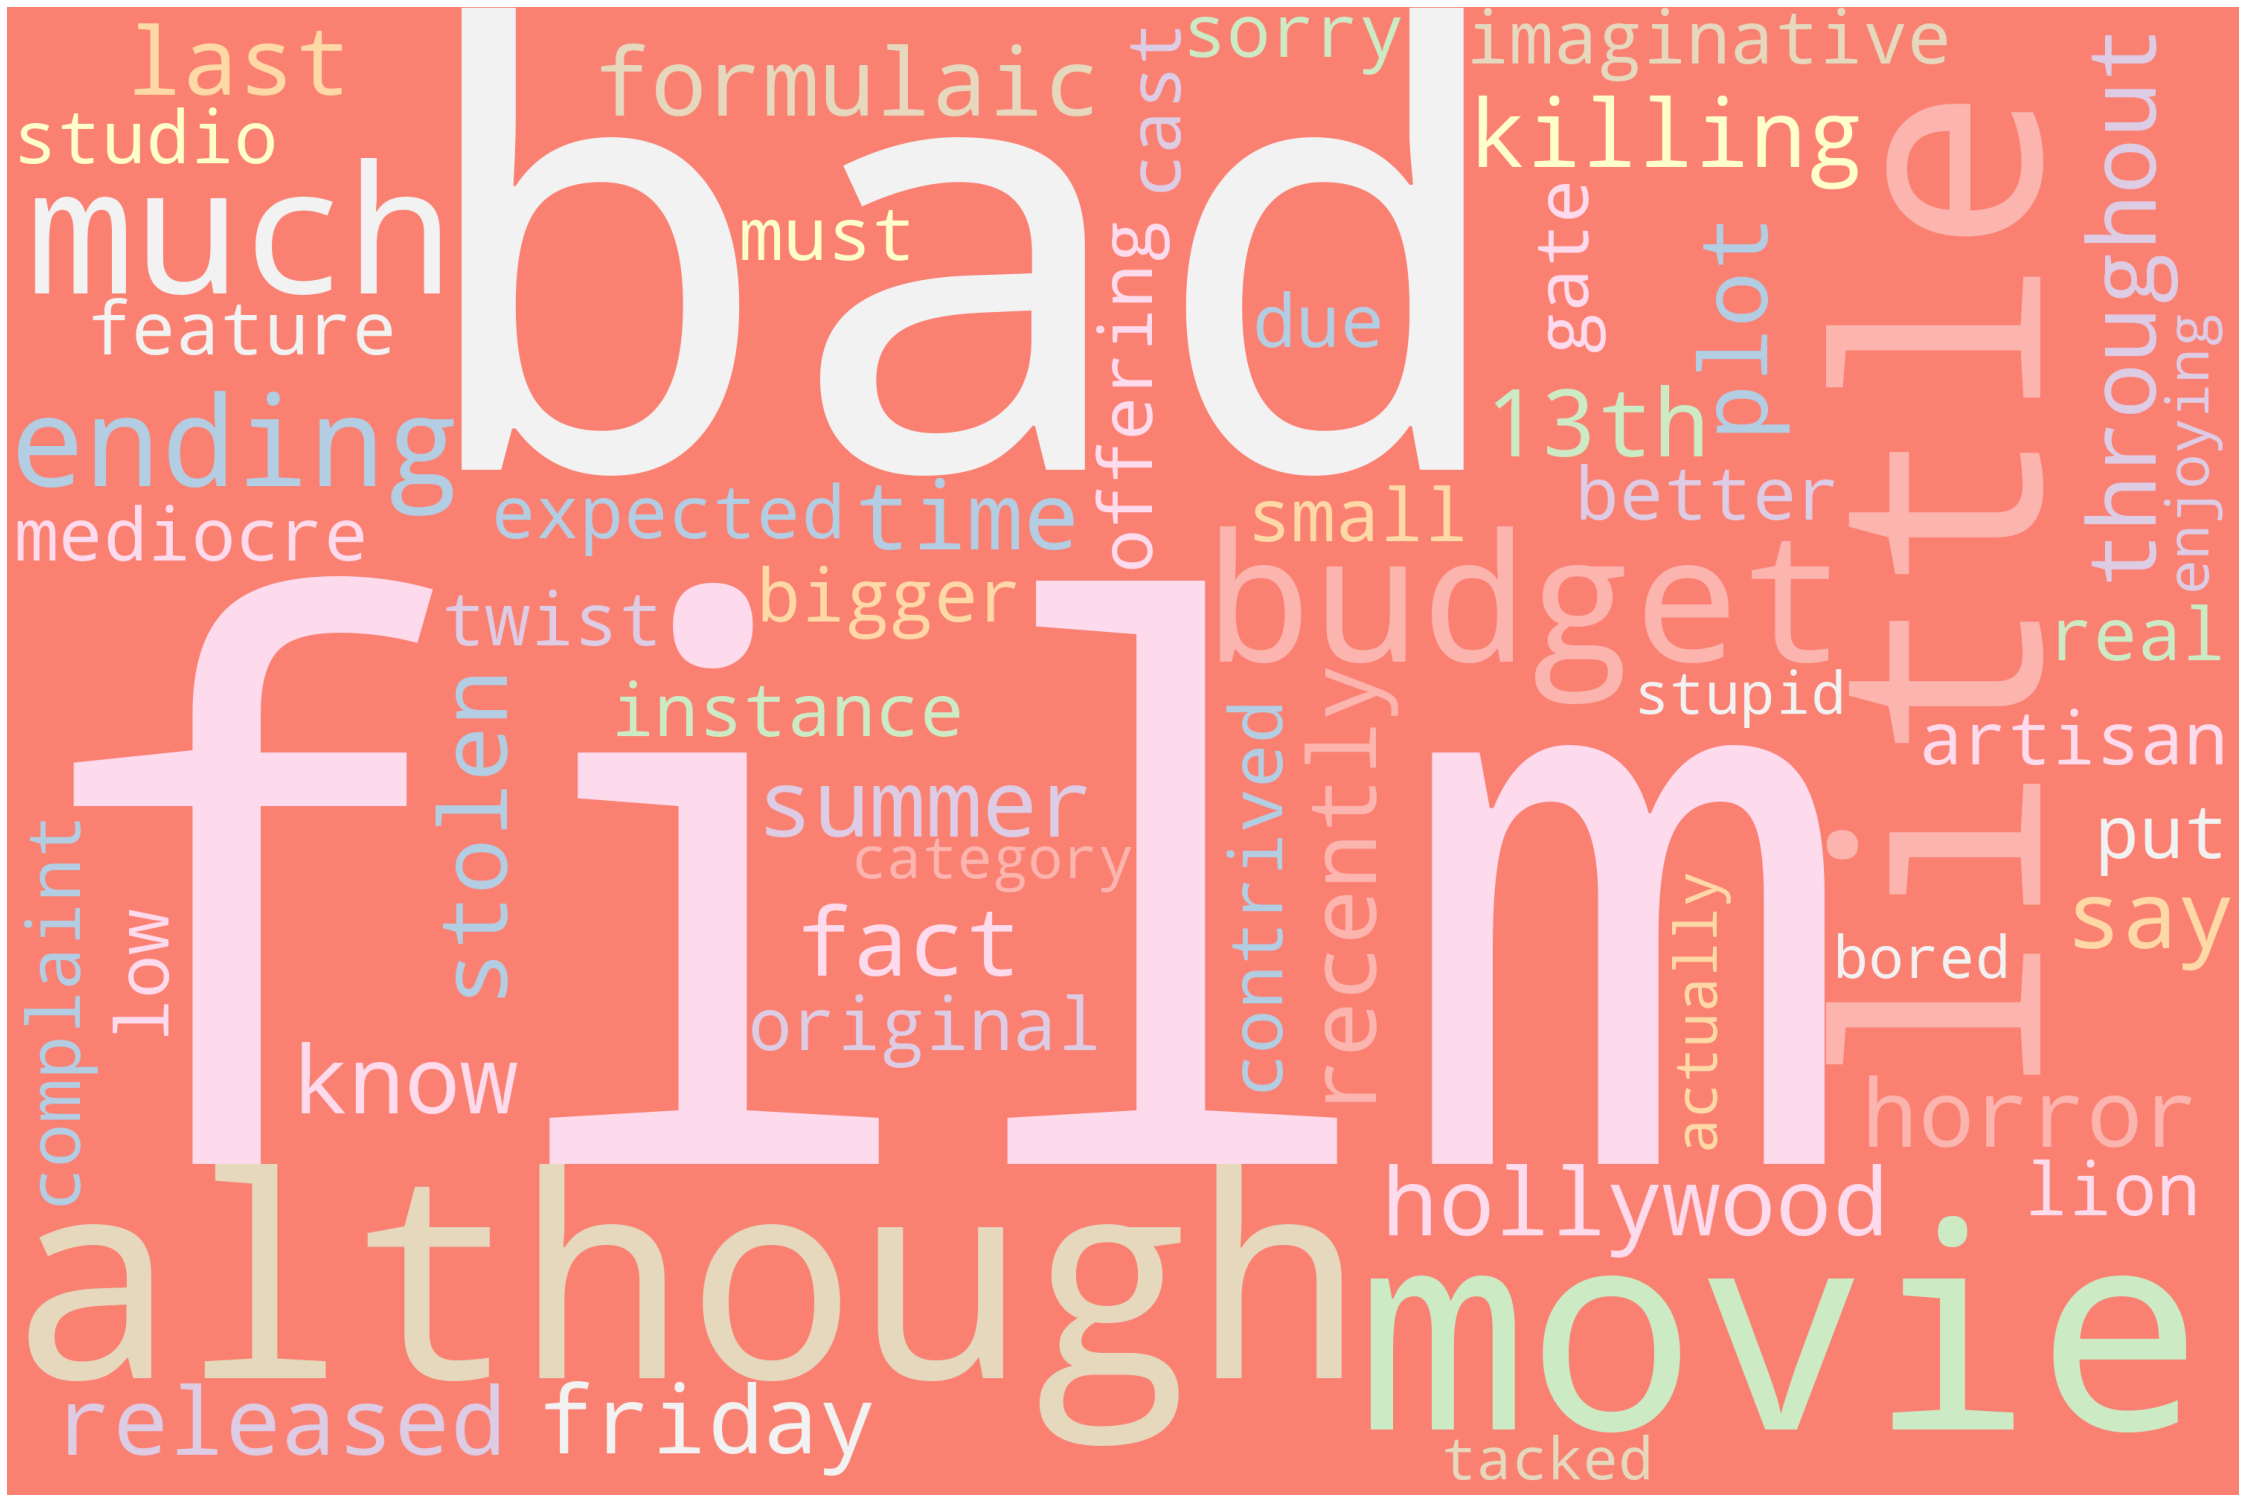

In [ ]:
lemmatized_word_cloud = (WordCloud(width=3000, 
                                  height=2000, 
                                  background_color='salmon', 
                                  colormap='Pastel1', 
                                  collocations=False, 
                                  random_state=1)
                         .generate(X_lemmatized[171]))

plt.figure(figsize=(40, 30))
plt.imshow(lemmatized_word_cloud)
plt.axis("off")

(-0.5, 2999.5, 1999.5, -0.5)

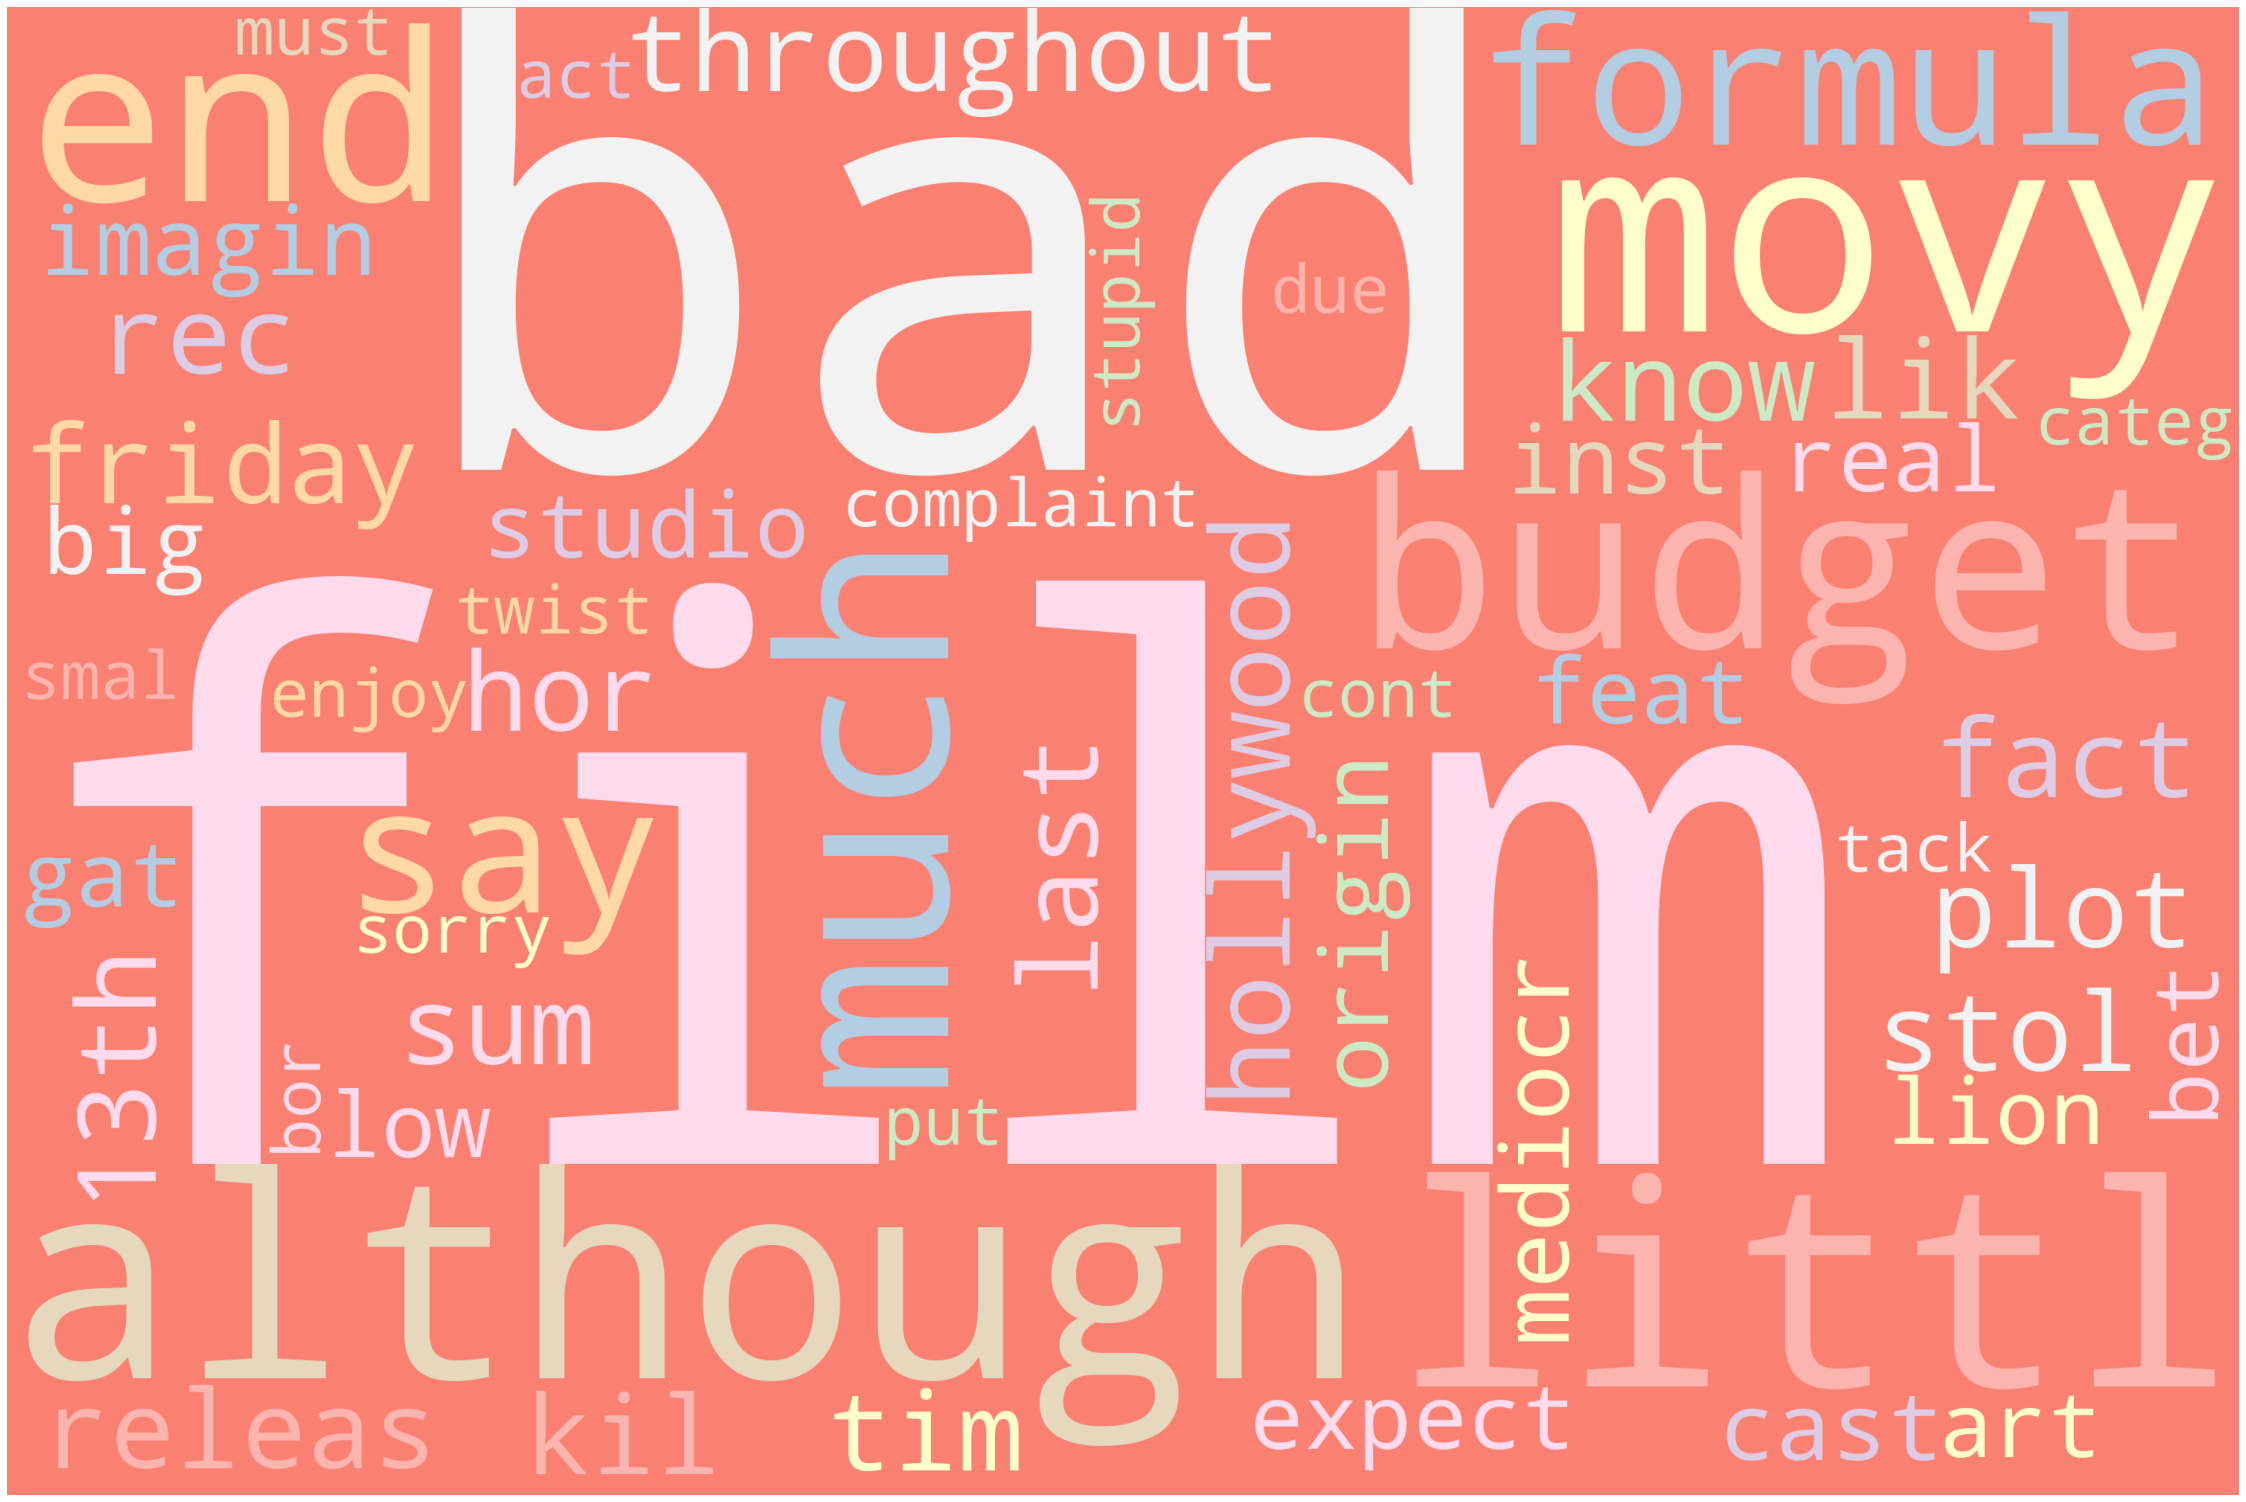

In [32]:
stemmed_word_cloud = (WordCloud(width=3000, 
                                  height=2000, 
                                  background_color='salmon', 
                                  colormap='Pastel1', 
                                  collocations=False, 
                                  random_state=1)
                         .generate(X_stemmed[171]))

plt.figure(figsize=(40, 30))
plt.imshow(stemmed_word_cloud)
plt.axis("off")

Given these visualizations, we can easily observe that that words like "bad" or "film" will be quite common. We can also the difference in stemming vs. lemmatizing.

Our last step now is Vectorization.
### Vectorization
This step is vital for the classification, as it transforms our text data to a numerical value. There are a few versions of this, and I chose to use a Binary Vector and a Count Vector.

A Binary Vector is a vector where the appearance of a word is noted, but not the amount of times it appears.

A Count Vector is a vector where the appearance of a word is noted, and the amount is tracked.

This subtle difference means a lot in terms of predictions.

In [35]:
%%time

binary_vector = CountVectorizer(ngram_range=(1, 2), binary=True)
count_vector = CountVectorizer(ngram_range=(1, 2))

Xb_stemmed = binary_vector.fit_transform(X_stemmed)
Xc_stemmed = count_vector.fit_transform(X_stemmed)

Xb_lemmatized = binary_vector.fit_transform(X_lemmatized)
Xc_lemmatized = count_vector.fit_transform(X_lemmatized)

CPU times: user 1min 52s, sys: 2.05 s, total: 1min 54s
Wall time: 1min 56s


## Classification
### Train-Test Split

Given these vectors, we can now create a Train-Test split for our data. This is used for training our models.

In [39]:
Xbs_train, Xbs_test, ybs_train, ybs_test = train_test_split(Xb_stemmed, y)
Xcs_train, Xcs_test, ycs_train, ycs_test = train_test_split(Xc_stemmed, y)

Xbl_train, Xbl_test, ybl_train, ybl_test = train_test_split(Xb_lemmatized, y)
Xcl_train, Xcl_test, ycl_train, ycl_test = train_test_split(Xc_lemmatized, y)

### Bernoulli Naive Bayes

The BernoulliNB is a classifier based on the Naive Bayes Assumption, in that we assume all events are independent. This assumption is wild, but allows for quite accurate calculations.

SKlearn implements a class for BernoulliNB, which is what is used for this class.

#### Hyperparameter Tuning
##### Stemmed

In [40]:
%%time

param_grid = {"alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2]}

bernoulli_grid = GridSearchCV(BernoulliNB(), param_grid, n_jobs=-1).fit(Xbs_train, ybs_train)

print("Binary")
print(f"Best Score: {bernoulli_grid.best_score_}") 
print(f"Optimal Values: {bernoulli_grid.best_params_}") 

bernoulli_grid = GridSearchCV(BernoulliNB(), param_grid, n_jobs=-1).fit(Xcs_train, ycs_train)

print("Count")
print(f"Best Score: {bernoulli_grid.best_score_}") 
print(f"Optimal Values: {bernoulli_grid.best_params_}") 

Binary
Best Score: 0.8644999999999999
Optimal Values: {'alpha': 0.2}
Count
Best Score: 0.8641
Optimal Values: {'alpha': 0.2}
CPU times: user 744 ms, sys: 270 ms, total: 1.01 s
Wall time: 10.1 s


##### Lemmatized

In [41]:
%%time

param_grid = {"alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2]}

bernoulli_grid = GridSearchCV(BernoulliNB(), param_grid, n_jobs=-1).fit(Xbl_train, ybl_train)

print("Binary")
print(f"Best Score: {bernoulli_grid.best_score_}") 
print(f"Optimal Values: {bernoulli_grid.best_params_}") 

bernoulli_grid = GridSearchCV(BernoulliNB(), param_grid, n_jobs=-1).fit(Xcl_train, ycl_train)

print("Count")
print(f"Best Score: {bernoulli_grid.best_score_}") 
print(f"Optimal Values: {bernoulli_grid.best_params_}") 

Binary
Best Score: 0.8712
Optimal Values: {'alpha': 0.2}
Count
Best Score: 0.8694666666666666
Optimal Values: {'alpha': 0.5}
CPU times: user 803 ms, sys: 249 ms, total: 1.05 s
Wall time: 11.5 s


#### Ideal Models
Given these parameters, we can determine the ideal model and its Confusion Matrix and Classification Report.

##### Stemmed

In [42]:
%%time

ideal_bernoulli = BernoulliNB(alpha=0.2).fit(Xbs_train, ybs_train)

ys_pred = ideal_bernoulli.predict(Xbs_test)

print("Confusion Matrix")
print(confusion_matrix(ybs_test, ys_pred))
print()
print(classification_report(ybs_test, ys_pred))
print()

Confusion Matrix
[[4491  499]
 [ 870 4140]]

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4990
           1       0.89      0.83      0.86      5010

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000


CPU times: user 408 ms, sys: 88.3 ms, total: 496 ms
Wall time: 496 ms


##### Lemmatized

In [43]:
%%time

ideal_bernoulli = BernoulliNB(alpha=0.2).fit(Xbl_train, ybl_train)

yl_pred = ideal_bernoulli.predict(Xbl_test)

print("Confusion Matrix")
print(confusion_matrix(ybl_test, yl_pred))
print()
print(classification_report(ybl_test, yl_pred))
print()

Confusion Matrix
[[4549  443]
 [ 794 4214]]

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4992
           1       0.90      0.84      0.87      5008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


CPU times: user 440 ms, sys: 141 ms, total: 581 ms
Wall time: 581 ms


### Multinomial Naive Bayes
The second Naive Bayes Classifier is based on the generalized Binomial Theorem, that is the Multinomial Theorem. It has many of the same ideas as BernoulliNB, but has differences in how it classifies.

#### Hyperparameter Tuning
##### Stemmed

In [44]:
%%time

param_grid = {"alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2]}

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid, n_jobs=-1).fit(Xbs_train, ybs_train)

print("Binary")
print(f"Best Score: {multinomial_grid.best_score_}") 
print(f"Optimal Values: {multinomial_grid.best_params_}") 

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid, n_jobs=-1).fit(Xcs_train, ycs_train)

print("Count")
print(f"Best Score: {multinomial_grid.best_score_}") 
print(f"Optimal Values: {multinomial_grid.best_params_}") 

Binary
Best Score: 0.8801333333333332
Optimal Values: {'alpha': 2}
Count
Best Score: 0.8748666666666667
Optimal Values: {'alpha': 1}
CPU times: user 747 ms, sys: 673 ms, total: 1.42 s
Wall time: 8.81 s


##### Lemmatized

In [45]:
%%time

param_grid = {"alpha": [0.001, 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2]}

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid, n_jobs=-1).fit(Xbl_train, ybl_train)

print("Binary")
print(f"Best Score: {multinomial_grid.best_score_}") 
print(f"Optimal Values: {multinomial_grid.best_params_}") 

multinomial_grid = GridSearchCV(MultinomialNB(), param_grid, n_jobs=-1).fit(Xcl_train, ycl_train)

print("Count")
print(f"Best Score: {multinomial_grid.best_score_}") 
print(f"Optimal Values: {multinomial_grid.best_params_}") 

Binary
Best Score: 0.8838666666666667
Optimal Values: {'alpha': 1}
Count
Best Score: 0.8789666666666667
Optimal Values: {'alpha': 1}
CPU times: user 840 ms, sys: 191 ms, total: 1.03 s
Wall time: 8.41 s


#### Ideal Models
##### Stemmed

In [47]:
%%time

ideal_multinomial = MultinomialNB(alpha=2).fit(Xbs_train, ybs_train)

ys_pred = ideal_multinomial.predict(Xbs_test)

print("Confusion Matrix")
print(confusion_matrix(ybs_test, ys_pred))
print()
print(classification_report(ybs_test, ys_pred))
print()

Confusion Matrix
[[4443  547]
 [ 704 4306]]

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4990
           1       0.89      0.86      0.87      5010

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000


CPU times: user 254 ms, sys: 17.7 ms, total: 271 ms
Wall time: 272 ms


##### Lemmatized

In [48]:
%%time

ideal_multinomial = MultinomialNB(alpha=1).fit(Xbl_train, ybl_train)

yl_pred = ideal_multinomial.predict(Xbl_test)

print("Confusion Matrix")
print(confusion_matrix(ybl_test, yl_pred))
print()
print(classification_report(ybl_test, yl_pred))
print()

Confusion Matrix
[[4502  490]
 [ 676 4332]]

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4992
           1       0.90      0.87      0.88      5008

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


CPU times: user 342 ms, sys: 54.5 ms, total: 397 ms
Wall time: 398 ms


### Decision Trees
The last classifier I chose to test was Decision Trees. From talking with my professor, it appears that in the NLP community Decision Trees are far more common than Naive Bayes Classifiers. As such I wanted to try one.

I chose to use a combination of Decision Trees and Random Forests for this. I did Hyperparameter Tuning with Decision Trees, then Random Forests with the ideal parameters.

But due to this, the results from the raw decision trees are awful, around $F_1$ Score of $0.6$. However, the results improve dramatically when done in the Random Forests.

#### Hyperparameter Tuning
##### Stemmed

In [51]:
%%time

param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 4, 0.5],
    "max_features": ["sqrt", "log2"]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=1).fit(Xbs_train, ybs_train)

print("Binary")
print(f"Best Score: {dt_grid.best_score_}")
print(f"Optimal Values: {dt_grid.best_params_}")

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=1).fit(Xcs_train, ycs_train)

print("Count")
print(f"Best Score: {dt_grid.best_score_}")
print(f"Optimal Values: {dt_grid.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Binary
Best Score: 0.6456666666666666
Optimal Values: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Count
Best Score: 0.6444333333333334
Optimal Values: {'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_split': 2}
CPU times: user 48 s, sys: 690 ms, total: 48.7 s
Wall time: 4min 51s


##### Lemmatized

In [52]:
%%time

param_grid = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 4, 0.5],
    "max_features": ["sqrt", "log2"]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=1).fit(Xbl_train, ybl_train)

print("Binary")
print(f"Best Score: {dt_grid.best_score_}")
print(f"Optimal Values: {dt_grid.best_params_}")

dt_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=1).fit(Xcl_train, ycl_train)

print("Count")
print(f"Best Score: {dt_grid.best_score_}")
print(f"Optimal Values: {dt_grid.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Binary
Best Score: 0.6659666666666666
Optimal Values: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 4}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Count
Best Score: 0.6616333333333333
Optimal Values: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_split': 4}
CPU times: user 49.8 s, sys: 210 ms, total: 50 s
Wall time: 5min 33s


#### Ideal Model
##### Stemmed

In [54]:
%%time

ideal_rf = RandomForestClassifier(n_jobs=-1).fit(Xbs_train, ybs_train)

yb_pred = ideal_rf.predict(Xbs_test)

print("Confusion Matrix")
print(confusion_matrix(ybs_test, ys_pred))
print()
print(classification_report(ybs_test, ys_pred))
print()

Confusion Matrix
[[4443  547]
 [ 704 4306]]

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4990
           1       0.89      0.86      0.87      5010

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000


CPU times: user 34min 52s, sys: 2.34 s, total: 34min 55s
Wall time: 4min 47s


##### Lemmatized

In [55]:
%%time

ideal_rf = RandomForestClassifier(n_jobs=-1).fit(Xbl_train, ybl_train)

yl_pred = ideal_rf.predict(Xbl_test)

print("Confusion Matrix")
print(confusion_matrix(ybl_test, yl_pred))
print()
print(classification_report(ybl_test, yl_pred))
print()

Confusion Matrix
[[4199  793]
 [ 633 4375]]

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4992
           1       0.85      0.87      0.86      5008

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


CPU times: user 41min 14s, sys: 2.57 s, total: 41min 16s
Wall time: 5min 39s


## Conclusion

All three of the models failed to reach the ideal $F_1$ Score of $0.9$. This issue leads to a pretty good, but not great model. Thus, the ideal model - which will be shown in a pipeline later on - isn't the best. However, the results show the difference between stemming and lemmatizing as well. In my case, the lack of knowledge when it came to determining the part of speech hurt how the lemmatizer was able to operate.

Much of this was a learning experience, and I quite enjoyed it. I like what NLP offers as a field of research, and it's definitely something I could see myself exploring more.

### Ideal Pipeline

In [57]:

# With a Lemmatized Text
ideal_pipeline = Pipeline([
    ("vect", CountVectorizer(ngram_range=(1, 2), binary=True)),
    ("clf", MultinomialNB(alpha=1))
])

## References
https://dl.acm.org/doi/abs/10.1145/101306.101310

https://www.nltk.org/index.html